## This notebook shows examples of how to use the cyclops.processor API on MIMIC-IV.

## Get all patients from the 1st Jan 2009 to 6th Jan 2009, join with diagnoses, labs, care-unit (transfers) information and vitals data.

In [ ]:
import random

import matplotlib.pyplot as plt
import pandas as pd

from cyclops.feature_handler import FeatureHandler
from cyclops.processor import featurize
from cyclops.processors.aggregate import Aggregator
from cyclops.processors.column_names import (
    ADMIT_TIMESTAMP,
    AGE,
    CARE_UNIT,
    DIAGNOSIS_CODE,
    ENCOUNTER_ID,
    SEX,
    YEAR,
)
from cyclops.processors.impute import Imputer
from cyclops.processors.util import gather_columns
from cyclops.query import mimic
from cyclops.query.postprocess.gemini import process_gemini_care_unit_changepoints
from cyclops.query.postprocess.util import plot_admit_discharge

In [ ]:
care_units = mimic.care_units().run()
greatest = list(care_units["encounter_id"].value_counts().index[:10])

encounter_id = greatest[0]  # SET encounter_id
care_units_i = care_units[care_units["encounter_id"] == encounter_id]
care_units_i = care_units_i.sort_values(by="admit")

In [ ]:
plot_admit_discharge(care_units_i, description=CARE_UNIT, figsize=(40, 4))

In [ ]:
process_gemini_care_unit_changepoints(care_units_i)

In [ ]:
patients = mimic.patients(from_date="2009-01-01", to_date="2009-01-06")
patients_diagnoses = mimic.diagnoses(patients=patients)
patients_labs = mimic.events(patients=patients, category="labs")
patients_vitals = mimic.events(patients=patients, category="routine vital signs")
patients_diagnoses.run(filter_recognised=True)
patients_labs.run(filter_recognised=True)
patients_vitals.run(filter_recognised=True)
patients_transfers = mimic.care_units(patients=patients)
patients_transfers.run()

print(f"{len(patients_diagnoses.data)} rows extracted!")
print(f"{len(patients_labs.data)} rows extracted!")
print(f"{len(patients_vitals.data)} rows extracted!")
print(f"{len(patients_transfers.data)} rows extracted!")

patients_diagnoses.save(".", "diagnoses")
patients_labs.save(".", "labs")
patients_vitals.save(".", "vitals")
patients_transfers.save(".", "transfers")

## Process queried data into features. (Static + Temporal).

In [ ]:
diagnoses_data = pd.read_parquet("diagnoses.gzip")
vitals_data = pd.read_parquet("vitals.gzip")
labs_data = pd.read_parquet("labs.gzip")
transfers_data = pd.read_parquet("transfers.gzip")

static_diagnoses_data = gather_columns(
    diagnoses_data,
    [ENCOUNTER_ID, AGE, SEX, DIAGNOSIS_CODE, ADMIT_TIMESTAMP],
)
feature_handler = featurize(
    static_data=[static_diagnoses_data],
    temporal_data=[labs_data, vitals_data],
    aggregator=Aggregator(bucket_size=6, window=120),
    static_imputer=Imputer(
        strategy="median",
        encounter_missingness_threshold=0.25,
        feature_missingness_threshold=0.5,
    ),
    temporal_imputer=Imputer(
        strategy="median",
        encounter_missingness_threshold=0.95,
        feature_missingness_threshold=0.75,
    ),
    reference_cols=[ADMIT_TIMESTAMP],
)

## Plot example temporal features.

In [ ]:
encounter_ids = list(
    set(feature_handler.features["temporal"].index.get_level_values(0))
)
encounter_id = random.choice(encounter_ids)
temporal_features = feature_handler.get_numerical_feature_names()["temporal"]
feature_handler.plot_features(encounter_id, names=temporal_features)

## Plot histogram of static features.

In [ ]:
feature_handler.plot_features(aggregate_type="static", names="age")

## Create new FeatureHandler and load features from file.

In [ ]:
feature_handler.save(".", "test_features")
feature_handler = FeatureHandler()
feature_handler.load(".", "test_features")

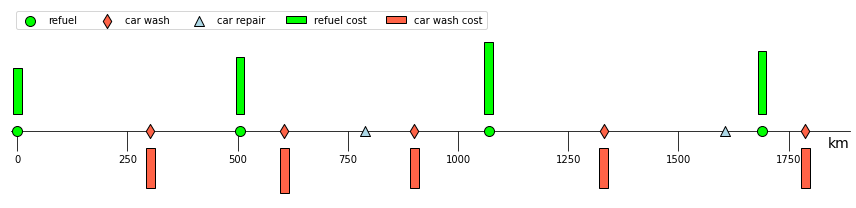

In [4]:
import matplotlib.pyplot as plt
import numpy as np

refuel_km = np.array([0, 505.4, 1070, 1690])
refuel_cost = np.array([40.1, 50, 63, 55])

carwash_km = np.array([302.0, 605.4, 901, 1331, 1788.2])
carwash_cost = np.array([35.0, 40.0, 35.0, 35.0, 35.0])

repair_km = np.array([788.0, 1605.4])
repair_cost = np.array([135.0, 74.5])

fig, ax = plt.subplots(figsize=(12, 3))

plt.scatter(
    refuel_km,
    np.full_like(refuel_km, 0),
    marker="o",
    s=100,
    color="lime",
    edgecolors="black",
    zorder=3,
    label="refuel",
)
plt.bar(
    refuel_km,
    refuel_cost,
    bottom=15,
    color="lime",
    ec="black",
    width=20,
    label="refuel cost",
)

plt.scatter(
    carwash_km,
    np.full_like(carwash_km, 0),
    marker="d",
    s=100,
    color="tomato",
    edgecolors="black",
    zorder=3,
    label="car wash",
)
plt.bar(
    carwash_km,
    -carwash_cost,
    bottom=-15,
    color="tomato",
    ec="black",
    width=20,
    label="car wash cost",
)

plt.scatter(
    repair_km,
    np.full_like(repair_km, 0),
    marker="^",
    s=100,
    color="lightblue",
    edgecolors="black",
    zorder=3,
    label="car repair",
)
# plt.bar(repair_km, -repair_cost, bottom=-15, color='lightblue', ec='black', width=20)

ax.spines["bottom"].set_position("zero")
ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")
ax.spines["left"].set_color("none")
ax.tick_params(axis="x", length=20)
ax.set_yticks([])  # turn off the yticks

_, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.set_xlim(-15, xmax)
ax.set_ylim(ymin, ymax + 25)  # make room for the legend
ax.text(xmax, -5, "km", ha="right", va="top", size=14)
plt.legend(ncol=5, loc="upper left")

plt.tight_layout()
plt.show()